# GitHub

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd /content/gdrive/My Drive/Github
%cd parallel-stencil-unstructured/
%ls -a

/content/gdrive/My Drive/Github
/content/gdrive/My Drive/Github/parallel-stencil-unstructured
 .git/  'Swept with advance clean.ipynb'


In [ ]:
!git status

On branch master
Your branch is up to date with 'origin/master'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   Swept with advance clean.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add  .

## Commit

In [ ]:
!git config --global user.email "moislam@mit.edu"
!git config --global user.name "Mohammad Islam"

In [ ]:
!git commit -m "Committing various approaches to performing the bridge step correctly in parallel (currently serial and parallel approaches give difference results)"

[master 1c3e43c] Committing various approaches to performing the bridge step correctly in parallel (currently serial and parallel approaches give difference results)
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite Swept with advance clean.ipynb (95%)


## Push

In [ ]:
!git push -u origin master

Counting objects: 3, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 142.97 KiB | 7.94 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/moislam1221/parallel-stencil-unstructured.git
   13632b4..1c3e43c  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


# Import

In [1]:
from pylab import *
from numpy import *
import scipy.io
from random import shuffle
from collections import defaultdict

In [2]:
pip install pymetis

     |████████████████████████████████| 307kB 6.8MB/s 
  Created wheel for pymetis: filename=PyMetis-2020.1-cp37-cp37m-linux_x86_64.whl size=274736 sha256=457dcc2b0bb8fffdba47781e7f87d82ed1d88d3770674a4e2d2acc1b85d6b35f
  Stored in directory: /root/.cache/pip/wheels/c6/95/04/af8144c2245c7562e1cc279b59ca502ff702f04184eb6ea9cf
Successfully built pymetis


In [3]:
import pymetis

In [ ]:
N = 7
neighbors = defaultdict(set)
for i in range(N):
  if i > 0:
    neighbors[i].add(i-1)
  if i < N-1:
    neighbors[i].add(i+1)
seeds = [{0},{N-1}]

print(neighbors)

groundLevel = zeros(N)
print(groundLevel)
iIter, territories, stopper, fronts = advance(seeds, 4, groundLevel)
groundLevel= frontsToGroundLevel(fronts)
print(groundLevel)
print(stopper)
print(territories)

defaultdict(<class 'set'>, {0: {1}, 1: {0, 2}, 2: {1, 3}, 3: {2, 4}, 4: {3, 5}, 5: {4, 6}, 6: {5}})
[0. 0. 0. 0. 0. 0. 0.]
[3. 2. 1. 0. 1. 2. 3.]
[3]
[0 0 0 0 1 1 1]


# Helper Functions

## Neighbors and xy coordinates

In [9]:
def create2Dneighbors(N, periodic=True, diagonalLinks=True):
    neighbors = defaultdict(set)
    for j in range(N):
        for i in range(N):
            dof = i + N*j
            # Left and right neighbors
            left = ((i-1) % N)+ N*j
            right = ((i+1) % N)+ N*j
            # Top and bottom neighbors
            top = i + N*((j+1) % N)
            bottom = i + N*((j-1) % N)
            # Diagonal neighbors
            ne = ((i+1) % N) + N*((j+1) % N)
            nw = ((i-1) % N) + N*((j+1) % N)
            se = ((i+1) % N) + N*((j-1) % N)
            sw = ((i-1) % N) + N*((j-1) % N)
            # Add all the neighbors
            if diagonalLinks == True:
                if periodic == True:
                    neighbors[dof].add(left)
                    neighbors[dof].add(right)
                    neighbors[dof].add(top)
                    neighbors[dof].add(bottom)
                    neighbors[dof].add(ne)
                    neighbors[dof].add(nw)
                    neighbors[dof].add(se)
                    neighbors[dof].add(sw)
                else:
                    if i > 0:
                        neighbors[dof].add(left)
                    if i < N-1:
                        neighbors[dof].add(right)
                    if j < N-1:
                        neighbors[dof].add(top)
                    if j > 0:
                        neighbors[dof].add(bottom)
                    # if dof != N*N-1:
                    if i < N-1 and j < N-1:
                        neighbors[dof].add(ne)
                    # if dof != N*N-N:
                    if i > 0 and j < N-1:
                        neighbors[dof].add(nw)
                    # if dof != N-1:
                    if i < N-1 and j > 0:
                        neighbors[dof].add(se)
                    # if dof != 0:
                    if i > 0 and j > 0:
                        neighbors[dof].add(sw)
            else:
                if periodic == True:
                    neighbors[dof].add(left)
                    neighbors[dof].add(right)
                    neighbors[dof].add(top)
                    neighbors[dof].add(bottom)
                else:
                    if i > 0:
                        neighbors[dof].add(left)
                    if i < N-1:
                        neighbors[dof].add(right)
                    if j < N-1:
                        neighbors[dof].add(top)
                    if j > 0:
                        neighbors[dof].add(bottom)
    return neighbors

def coordinatesRectangle(N):
    xy = np.zeros((N*N,2))
    dx = 1.0/N
    x = np.linspace(dx/2,1.0-dx/2,N)
    for dof in arange(len(neighbors)):
        idx = int(dof % N)
        idy = int(dof / N)
        xy[dof,:] = np.array((x[idx], x[idy]))
    return xy

## Advance Function

In [10]:
def advance(seeds, nIters, groundLevel):
    fronts = [{1:set(s)} for s in seeds]
    # territories = -ones(len(neighbors), int)
    territories = -ones(len(groundLevel), int)
    for i in range(len(seeds)):
        # print("The " + str(i) + "th seed")
        for p in seeds[i]:
            territories[p] = i
            # print("DOF " + str(p))
    stopper = set()
    iIter = 0
    while iIter + 1 != nIters:
        for iSeed in range(len(seeds)):
            fronts[iSeed][0] = set()
            for ilevel in range(iIter+1, 0, -1):
                for pFront in fronts[iSeed][ilevel]:
                    for pNbr in neighbors[pFront]:
                        if territories[pNbr] < 0 and groundLevel[pNbr] < ilevel:
                            fronts[iSeed][ilevel-1].add(pNbr)
                            territories[pNbr] = iSeed
                        elif territories[pNbr] != iSeed and groundLevel[pNbr] < ilevel:
                            stopper.add(pNbr)
            for ilevel in range(iIter+1, -1, -1):
                fronts[iSeed][ilevel+1] = fronts[iSeed][ilevel]
            del fronts[iSeed][0] 
        if len(stopper):
            break
        iIter = iIter+1
    return iIter, territories, array(list(stopper)), fronts

def checkTerritoriesIntersect(territories):
    territoriesIntersect = False
    numSubdomains = np.max(territories)
    territoriesDofs = []
    for s in np.arange(numSubdomains):
        dofs = np.where(territories == s)
        for dof in dofs[0]:
            for neighbor in list(neighbors[dof]):
                if territories[neighbor] != -1 and territories[neighbor] != s:
                    territoriesIntersect = True
    return territoriesIntersect

def advanceNotAdjacent(seeds, nIters):
    fronts = [{1:set(s)} for s in seeds]
    territories = -ones(len(neighbors), int)
    for i in range(len(seeds)):
        for p in seeds[i]:
            territories[p] = i
    territoriesOld = territories.copy()
    stopper = set()
    iIter = 0
    while iIter + 1 != nIters:
        for iSeed in range(len(seeds)):
            fronts[iSeed][0] = set()
            for ilevel in range(iIter+1, 0, -1):
                for pFront in fronts[iSeed][ilevel]:
                    for pNbr in neighbors[pFront]:
                        if territories[pNbr] < 0:
                            fronts[iSeed][ilevel-1].add(pNbr)
                            territories[pNbr] = iSeed
                        elif territories[pNbr] != iSeed:
                            stopper.add(pNbr)
            for ilevel in range(iIter+1, -1, -1):
                fronts[iSeed][ilevel+1] = fronts[iSeed][ilevel]
            del fronts[iSeed][0] 
        territoriesIntersect = checkTerritoriesIntersect(territories)
        if territoriesIntersect == True:
            break
        territoriesOld = territories.copy()
        iIter = iIter+1
    return iIter, territoriesOld, array(list(stopper)), fronts

def frontsToGroundLevel(fronts):
    for front in fronts:
        for level, points in front.items():
            for point in points:
                groundLevel[point] = level-1
    return groundLevel

## Finding seeds

In [11]:
# STEPS:
# 1 - For each seed set, obtain all the possible neighbors - OK
# 2 - Given the seed set and the possible neighbors, loop through neighbors - OK
# 3 - For each neighbor, add it to the path. Find the next neighbor that is (a) neighbor of current dof, (b) in filament, (c) not seed
# 4 - Determine the dx and dy, and check if the most recent dof has any dof perpendicular to it and add that to the path
# 5 - Loop 3 and 4 until we are about to add a neighbor that is in the seedsList (dont add it and end the path)

def findSeeds(N, nSubdomains):
    # Create array containing how many DOFs per subdomain
    pointsInSubdomain = zeros(nSubdomains, dtype=int)
    nPerSubdomain = round(N / nSubdomains)
    for i in arange(nSubdomains):
        pointsInSubdomain[i] = int(nPerSubdomain)
    if sum(pointsInSubdomain) != N:
        lastNumberOfDofs = N - sum(pointsInSubdomain[:-1])
        pointsInSubdomain[-1] = int(lastNumberOfDofs)
    count = 0
    while abs(pointsInSubdomain[-1] - nPerSubdomain) > 1:
        if pointsInSubdomain[-1] - nPerSubdomain > 1:
            pointsInSubdomain[-1] -= 1
            pointsInSubdomain[count] += 1
        elif nPerSubdomain - pointsInSubdomain[-1] > 1:
            pointsInSubdomain[-1] += 1
            pointsInSubdomain[count] -= 1
        count += 1
    pointsInSubdomain = np.array(sorted(pointsInSubdomain))
    # Partition domain into the subdomains
    domain = zeros((N,N), dtype=int)
    for j in arange(N):
        for i in arange(N):
            domain[i, j] = int(j + i * N)
    subdomainList = []
    for i in arange(nSubdomains):
        for j in arange(nSubdomains):
            xInit = sum(pointsInSubdomain[0:i])
            xFinal = sum(pointsInSubdomain[0:i+1])
            yInit = sum(pointsInSubdomain[0:j])
            yFinal = sum(pointsInSubdomain[0:j+1])
            subdomain = domain[xInit : xFinal, yInit : yFinal]
            subdomainList.append(subdomain)
    # Determine the seed dofs corresponding to each subdomain
    seeds = []
    # Modified approach - working on it
    # (a): Iterate on subdomains to see how many iterations can be performed
    iterationList = []
    for subdomain in subdomainList:
        subdomain = list(np.concatenate(subdomain))
        iter = 0
        while len(subdomain) > 0:
            iter = iter + 1
            subdomainNext = []
            subdomainCurr = subdomain
            for dof in subdomain:
                addToNext = True
                for neighbor in neighbors[dof]:
                    if neighbor not in subdomain:
                        addToNext = False
                if addToNext == True:
                    subdomainNext.append(dof)
            subdomain = subdomainNext
        iterationList.append(iter)
    # (b): Perform number of iterations that is minumum for all sets to the 
    # the appropriate seed
    iterationsToDo = min(iterationList) 
    for i in arange(len(subdomainList)):
        subdomain = subdomainList[i]
        subdomain = list(np.concatenate(subdomain))
        for iter in arange(iterationsToDo):
            subdomainNext = []
            subdomainCurr = subdomain
            for dof in subdomain:
                addToNext = True
                for neighbor in neighbors[dof]:
                    if neighbor not in subdomain:
                        addToNext = False
                if addToNext == True:
                    subdomainNext.append(dof)
            subdomain = subdomainNext
        seeds.append(set(subdomainCurr))
    return seeds

## STEPS
# 1 - determine the lowest level region and pick a random point
# 2 - check all points that lie in region and also are neighbors of that poit
# 3 - check what territories each of the dofs in step 2 are associated with
# 4 - if 4 different territories are present, keep track of the territories. Add our
# original point and its territory. For each dof, if it is part of a new territory
# add the dof and record the territory
# 5 - Check that the four dofs are neighbors of one another
def findSeedsDual(groundLevel, territories):
    dualDofs = []
    nIters = 1000
    for iter in arange(nIters):
        # STEP 1
        minIter = min(groundLevel)
        potentialDualDof = set(np.where(groundLevel == minIter)[0])
        dualDofInit = random.choice(list(potentialDualDof))
        # STEP 2
        neighborsOfDualDofInit = neighbors[dualDofInit]
        dualDofsAttached = potentialDualDof.intersection(neighborsOfDualDofInit)
        # STEP 3
        territoryIDs = set()
        territoryInit = territories[dualDofInit]
        territoryIDs.add(territoryInit)
        for dof in dualDofsAttached:
            territoryID = territories[dof] 
            territoryIDs.add(territoryID)
        # STEP 4
        if len(territoryIDs) == 4:
            territoryTracker = [territoryInit]
            dofTracker = [dualDofInit]
            dualDofsAttached = list(dualDofsAttached)
            random.shuffle(dualDofsAttached)
            for dof in dualDofsAttached:
                territory = territories[dof]
                if territory not in territoryTracker:
                    territoryTracker.append(territory)
                    dofTracker.append(dof)
            #print(dofTracker)
            # STEP 5
            acceptDualDof = True
            for dofMain in dofTracker:   
                for dofSub in dofTracker:
                    if dofMain != dofSub:
                        if dofSub not in neighbors[dofMain]:
                            acceptDualDof = False
            # Add the dualDof if accept dual dof is true
            dualDofsToAdd = set(dofTracker)
            if acceptDualDof == True and dualDofsToAdd not in dualDofs:
                dualDofs.append(set(dofTracker))

    return dualDofs

def simpleBridges(filament, seeds):
    allSeeds = set()
    for i in arange(len(seeds)):
        allSeeds.update(seeds[i])
    allBridges = []
    allBridges = filament.difference(allSeeds)   
    return allBridges

## Plotting

In [12]:
def plotGroundLevel(groundLevel, N):
    figure()
    imshow(reshape(groundLevel, [N,N]))
    colorbar()
    return

def plotSeeds(seedsSet, N):
    ground = zeros(N*N)
    for seed in seedsSet:
        dof = list(seed)
        ground[dof] = 1
    figure()
    imshow(reshape(ground,[N,N]))

def plotBridges(bridgesList, N):
    numBridges = len(bridgesList)
    fig, axs = plt.subplots(1,numBridges)
    for i in range(numBridges):
        bridge = bridgesList[i]
        ground = zeros(N*N)
        dofs = list(bridge)
        ground[dofs] = 1
        # fig.imshow(reshape(ground,[N,N]))
        if numBridges > 1:
            axs[i].imshow(reshape(ground,[N,N]))
        else:
            axs.imshow(reshape(ground,[N,N]))

def plotTerritories(territories, N):
    numTerritories = max(territories) + 1
    fig, axs = plt.subplot(1, numTerritories)
    for i in arange(0,max(territories)+1):
        ground = zeros(N*N)
        dofs = np.where(territories == i)[0]
        ground[dofs] = 1
        if numTerritories > 1:
            axs[i].imshow(reshape(ground,[N,N]))
        else:
            axs.imshow(reshape(ground,[N,N]))

def plotTerritoriesAll(territories, N):
    ground = zeros(N*N)
    for i in arange(0,max(territories)+1):
        dofs = np.where(territories == i)[0]
        ground[dofs] = 1
    figure()
    imshow(reshape(ground,[N,N]))
    colorbar()

def plotTerritoriesSet(territorySet, N):
    numTerritories = len(territorySet)
    fig, axs = plt.subplots(1, numTerritories)
    for i in range(len(territorySet)):
        ground = zeros(N*N)
        dofs = list(territorySet[i])
        ground[dofs] = 1
        if numTerritories > 1:
            axs[i].imshow(reshape(ground,[N,N]))
        else:
            axs.imshow(reshape(ground,[N,N]))

def plotTerritoriesAllSet(territorySet, N):
    ground = zeros(N*N)
    for i in range(len(territorySet)):
        dofs = list(territorySet[i])
        ground[dofs] = 1
    figure()
    imshow(reshape(ground,[N,N]))
    colorbar()

## Parallel Advance Functions

In [13]:
def expandTerritorySet(territorySet, neighbors):
    territorySetExpanded = []
    for i in range(len(territorySet)):
        setToAdd = set()
        for dof in list(territorySet[i]):
            setToAdd.add(dof)
            for neighbor in neighbors[dof]:
                setToAdd.add(neighbor)
        territorySetExpanded.append(setToAdd)
    return territorySetExpanded

def groundLevelPartition(groundLevel, territorySet, seeds, neighbors):
    groundLevelAllSubdomains = []
    for i in range(len(seeds)):
        subdomainListToAdd = defaultdict(list)
        for dof in territorySet[i]:
            subdomainListToAdd[dof] = int(groundLevel[dof])
        groundLevelAllSubdomains.append(subdomainListToAdd)
    return groundLevelAllSubdomains

def parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySet, seeds, nIters, neighbors):
    for i in range(len(seeds)):
        updateList = []
        updateList.append(seeds[i])
        levelStart = min(groundLevel)
        thresholdLevelList = [levelStart+1]
        for iter in range(nIters):
            updateListAll = []
            for idx in range(len(updateList)):
                updateListAll.append(list(updateList[idx]))
            updateListAll = concatenate(updateListAll)
            for s in range(len(updateList)):
                updateSetNext = set()
                for dof in updateList[s]:
                    ## update: check if all my neighbors present in subdomain before doing the update
                    updateDof = True
                    for neighbor in neighbors[dof]:
                        if neighbor not in groundLevelAllSubdomains[i]:
                            updateDof = False
                    currentLevel = groundLevelAllSubdomains[i][dof]
                    if currentLevel < thresholdLevelList[s] and updateDof == True:
                        groundLevelAllSubdomains[i][dof] = groundLevelAllSubdomains[i][dof] + 1
                        for neighbor in neighbors[dof]:
                            if neighbor in groundLevelAllSubdomains[i] and neighbor not in updateListAll:
                                if groundLevelAllSubdomains[i][neighbor] < thresholdLevelList[s]:
                                    if s < len(updateList)-1:
                                        updateList[s+1].add(neighbor)
                                    else:
                                        updateSetNext.add(neighbor)                                    
            for idx2 in range(len(thresholdLevelList)):
                thresholdLevelList[idx2] += 1
            thresholdLevelList.append(levelStart+1)
            updateList.append(updateSetNext)
            
    return groundLevelAllSubdomains

def groundLevelCombine(groundLevelInput, groundLevelAllSubdomains, territorySet = []):
    groundLevel = groundLevelInput.copy()
    for i in range(len(groundLevelAllSubdomains)):
        for dof in groundLevelAllSubdomains[i]:
            if len(territorySet) == 0:
                groundLevel[dof] = groundLevelAllSubdomains[i][dof]
            elif dof in territorySet[i]:
                groundLevel[dof] = groundLevelAllSubdomains[i][dof]
    return groundLevel

# STEP 1: UPPER PYRAMIDAL

## Functions

In [14]:
def findSeedsApart(neighbors, numSeeds):
    # Initialize stuff
    numDofs = len(neighbors)
    seeds = random.choice(numDofs, size=numSeeds, replace=False)
    seeds = [set([s]) for s in seeds]
    groundLevel = zeros(numDofs)
    maxIter = 0
    savedSeeds = []
    # Figure out how far apart (how many iters max) can be done
    for trial in range(2000):
        iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
        if iIter > maxIter:
            print(iIter)
            maxIter = iIter
            savedSeeds = seeds
        _, territories2,_,_ = advance([stopper], iIter+1, groundLevel)
        seeds = moveSeeds(seeds, territories2)
    # Find a seed configuration corresponding to this max iter
    #iIter = 0
    #while iIter < maxIter:
    #    _, territories2,_,_ = advance([stopper], iIter+1, groundLevel)
    #    seeds = moveSeeds(seeds, territories2)
    #    iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)
    #    print(iIter)
    seeds = savedSeeds
    return seeds

def createSubdomainsWithMETIS(neighbors, seeds, territories):
    # Create useful data structures containing seed, territory info
    territorySet = territorySetCreator(territories)
    seedsList, territoryList = seedAndTerritoryListCreator(seeds, territorySet)
    # Remove all neighbors of nodes lying in a territory
    for i in range(len(seeds)):
        for dof in territorySet[i]:
            neighbors[dof].clear()
    # Link seeds to all neighbors of the territory dofs
    neighborsOfTerritory = getNeighborsOfTerritory(seeds, territorySet)
    for i in range(len(seeds)):
        seedDof = list(seeds[i])[0]
        neighbors[seedDof] = set(neighborsOfTerritory[i])
    # Replace any territory dof in the connectivity with the representative seed
    for dof in range(len(neighbors)):
        for neighbor in neighbors[dof].copy():
            for i in range(len(seeds)):
                if neighbor in territorySet[i]:
                    neighbors[dof].remove(neighbor)
                    neighbors[dof].add(list(seeds[i])[0])
    # Create METIS adjacency list and vweights data structures (arrays)
    adjacency_list = []
    vweights = []
    ratioNonSeedToSeed = int(numDofs - len(seeds) / len(seeds))
    hugeFactor = 10000
    seedWeight = hugeFactor * ratioNonSeedToSeed
    for i in range(numDofs):
        adjacency_list.append(np.array(list(neighborsDummy[i])))
        if i in seedsList:
            vweights.append(seedWeight)
        else:
            vweights.append(1)
    # Use METIS to partition the domain
    numSubdomains = len(seeds)
    territorySetAllDofs = []
    n_cuts, membership = pymetis.part_graph(numSubdomains, adjacency=adjacency_list, vweights=vweights)
    for i in range(numSubdomains):
        nodes_partition = np.argwhere(np.array(membership) == i).ravel() # [3, 5, 6]
        territorySetAllDofs.append(set(nodes_partition))
    # Remove dofs which were in the territory but not the seed
    for sub in range(numSubdomains):
        for dof in territorySetAllDofs[sub].copy():
            if (dof not in seedsList):
                if dof in territoryList:
                    territorySetAllDofs[sub].remove(dof)
    # In each region, find the seed and augment the list with all the territory dofs corresponding to the seed
    metisToTerritories = []
    for sub in range(numSubdomains):
        for dof in territorySetAllDofs[sub].copy():
            if dof in seedsList:
                idx = np.where(dof == seedsList)[0][0]
                territorySetAllDofs[sub].update(territorySet[idx])
    return territorySetAllDofs

def upperPyramidal(territorySetAllDofs, neighbors):
    numSubdomains = len(territorySetAllDofs)
    iterationList = []
    # Determine max iters that can be performed overall (min of all iters)
    for s in range(numSubdomains):
        iter = 0
        currentDofs = list(territorySetAllDofs[s])
        while len(currentDofs) > 0:
            updatedDofs = []
            for dof in currentDofs:
                updateTheDof = True
                for n in neighbors[dof]:
                    if n not in currentDofs:
                        updateTheDof = False
                if updateTheDof == True:
                    updatedDofs.append(dof)
            currentDofs = updatedDofs
            if len(updatedDofs) > 0:
                iter = iter + 1
        iterationList.append(iter)
    # Obtain seeds from performing that many iterations
    iterationsToDo = min(iterationList) 
    seeds = []
    for s in range(numSubdomains):
        iter = 0
        currentDofs = list(territorySetAllDofs[s])
        for iter in range(iterationsToDo):
            updatedDofs = []
            for dof in currentDofs:
                updateTheDof = True
                for n in neighbors[dof]:
                    if n not in currentDofs:
                        updateTheDof = False
                if updateTheDof == True:
                    updatedDofs.append(dof)
            currentDofs = updatedDofs
        seeds.append(set(currentDofs))
    # Return seed values
    return seeds

In [15]:
def moveSeeds(seeds, territories):
    seedsNew = []
    territoryDofs = set(np.where(territories == 0)[0])
    p = np.random.rand()
    for s in seeds:
        neighborInStopperTerritory = False
        for dof in neighbors[list(s)[0]]:
            if dof in territoryDofs:
                neighborInStopperTerritory = True
        if (list(s)[0] in territoryDofs) or (neighborInStopperTerritory == True):
            potentialSeeds = neighbors[list(s)[0]].difference(territoryDofs)
            if len(potentialSeeds) > 0:
                seedsNew.append(random.choice(list(potentialSeeds)))
            else:
                seedsNew.append(list(s)[0])
        else:
            seedsNew.append(list(s)[0])
    seedsNew = [set([s]) for s in seedsNew]
    return seedsNew

def territorySetCreator(territories):
    territorySet = []
    for i in range(max(territories)+1):
        territoryDofs = set(np.where(territories == i)[0])
        territorySet.append(territoryDofs)
    return territorySet

def seedAndTerritoryListCreator(seeds, territorySet):
    seedsList = []
    territoryList = []
    for i in range(len(seeds)):
        seedsList.append(list(seeds[i])) 
        territoryList.append(list(territorySet[i]))
    seedsList = np.concatenate(seedsList)
    territoryList = np.concatenate(territoryList)
    return seedsList, territoryList

def getNeighborsOfTerritory(seeds, territorySet):
    neighborsOfTerritory = []
    for i in range(len(seeds)):
        territoryNeighbors = []
        for dof in territorySet[i]:
            territoryNeighbors.append(list(neighbors[dof]))
        neighborsOfTerritory.append(set(np.concatenate(territoryNeighbors)))
    for i in range(len(seeds)):
        neighborsOfTerritory[i] = set(neighborsOfTerritory[i]).difference(set(territorySet[i])) 
    return neighborsOfTerritory

# STEP 2: DUAL SEED UPDATE

## Functions

In [16]:
def findDualSeeds(groundLevel, territorySetUpperPyramidal, neighbors):
    # Find all dofs at the lowest iteration level after upper pyramidal
    minIter = min(groundLevel)
    potentialDualDofs = set(np.where(groundLevel == minIter)[0])
    potentialDualDofs.update(set(np.where(groundLevel == minIter+1)[0]))
    # Determine which dofs have the most territories represented in the set of points containing their neighbors and themselves
    territoriesRepByDof = numTerritoriesRepByNeighbors(potentialDualDofs, territorySetUpperPyramidal, neighbors)
    dualSeedDofs = potentialDualSeeds(territoriesRepByDof)
    # Group the dual seeds into different sets of points which are contiguous 
    dualSeeds = groupDualSeeds(dualSeedDofs, neighbors)
    return dualSeeds

def groupDualSeeds(dualSeedDofs, neighbors):  
    dualSeeds = []
    dofSet = set(dualSeedDofs)
    while(len(dofSet)) > 0:
        seedSet = set()
        seedSet.add(list(dofSet)[0])
        idx = 0
        repeat = True
        while repeat == True:
            dofMain = list(seedSet)[idx]
            repeat = False
            for dof2 in list(dofSet):
                if dofMain != dof2:
                    areNeighbors = determineIfDofsAreNeighbors(dofMain, dof2)
                    if areNeighbors == True and dof2 not in seedSet:
                        seedSet.add(dof2)
                        repeat = True
            if repeat == True:
                idx = idx + 1
        dofSet.difference_update(seedSet)
        dualSeeds.append(seedSet)
    return dualSeeds

def removeCloseSeeds(dualSeeds, iIter, groundLevel, neighbors):
    zeroGroundLevel = zeros(len(groundLevel))
    stopperExists = True
    while stopperExists == True:
        # Advance the dual seeds
        _, territories, stopper, _ = advance(dualSeeds, iIter, zeroGroundLevel)
        territorySet = territorySetCreator(territories)
        # plotTerritories(territories, N)
        # plotTerritoriesAll(territories, N)
        if len(stopper) > 0:
            stopperDof = random.choice(stopper)
            terrID = territoryFinder(territorySet, stopperDof)
            dualSeeds.remove(dualSeeds[terrID])
        else:
            stopperExists = False
    return dualSeeds

def numTerritoriesRepByNeighbors(dofSet, territorySetAllDofs, neighbors):
    # Obtain the number of territories represented by dof
    territoriesRepByDof = defaultdict()
    for dof in dofSet:
        territoryIDs = set()
        territoryIDs.add(territoryFinder(territorySetAllDofs, dof))
        neighborSet = neighbors[dof]
        for neighbor in neighborSet:  
            territoryID = territoryFinder(territorySetAllDofs, neighbor) 
            territoryIDs.add(territoryID)
        territoriesRepByDof[dof] = len(territoryIDs)
    return territoriesRepByDof

def potentialDualSeeds(territoriesRepByDof):
    max_value = max(territoriesRepByDof.values())  # maximum value
    print(max_value)
    dualSeedDofs = [k for k, v in territoriesRepByDof.items() if v == max_value] # getting all keys containing the `maximum`
    return dualSeedDofs

def determineIfDofsAreNeighbors(dof1, dof2):
    areNeighbors = False
    neighborSet = neighbors[dof1]
    for neighbor in neighborSet:
        if neighbor == dof2:
            areNeighbors = True
    return areNeighbors

def obtainFilamentBridgeRegion(dualSeeds, groundLevel):
    iIter, territories, stopper, fronts = advance(dualSeeds, max(groundLevel)-min(groundLevel), zeros(len(groundLevel)))
    #figure()
    #imshow(reshape(territories >= 0, [N,N]))
    #colorbar()
    filament = set(np.where(territories == -1)[0])  
    return filament

def filamentRemoveSeeds(filament, seeds):
    for i in range(len(seeds)):
        filament.difference_update(seeds[i])
    return filament

def territoryFinder(territorySetAllDofs, dof):
    territoryID = -1
    for i in range(len(territorySetAllDofs)):
        if dof in territorySetAllDofs[i]:
            territoryID = i
    if territoryID == -1:
        print("A territory wasn't found")
    return territoryID

In [18]:
def filamentConnectivityConstructor(filament, neighbors, groundLevel):
    filamentConnectivity = defaultdict()
    for dof in filament:
        allNeighbors = set()
        currentLevel = int(groundLevel[dof])
        maxLevel = int(max(groundLevel))
        mylist = set()
        if currentLevel < maxLevel:
            mylist.add(dof)
        levelGap = 1
        while len(mylist) > 0:
            lowDofs = set()
            for dofIter in mylist:
                for neighbor in neighbors[dofIter]:
                    allNeighbors.add(neighbor)
                    if groundLevel[neighbor] < maxLevel-levelGap:
                        lowDofs.add(neighbor)
            mylist = lowDofs.copy()
            levelGap += 1
        filamentConnectivity[dof] = allNeighbors
    return filamentConnectivity

# Construct a graph connecting all dofs in filaments to all other dofs, with weighting equal to intersection of regions of dependence
def filamentMappingforMETIS(filament):
    map = defaultdict()
    reverseMap = defaultdict()
    i = 0
    for dof in filament:
        map[dof] = i
        reverseMap[i] = dof 
        i += 1
    return map, reverseMap

def constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map):
    filamentMapped = set()
    filamentConnectivityMapped = defaultdict()
    for dof in filament:
        filamentMapped.add(map[dof])
        filamentConnectivityMapped[map[dof]] = filamentConnectivity[dof]
    return filamentMapped, filamentConnectivityMapped

def constructMETISDataStructures(filamentMapped, filamentConnectivityMapped):
    xadj = []
    adjncy = []
    eweights = []
    for dof in filamentMapped:
        xadj.append(len(adjncy))
        filamentMappedNoDof = filamentMapped.difference({dof})
        for dof2 in filamentMappedNoDof:
            eweight = len(filamentConnectivityMapped[dof].intersection(filamentConnectivityMapped[dof2]))
            if eweight > 0:
                adjncy.append(dof2)
                eweights.append(eweight)
    xadj.append(len(adjncy))
    return xadj, adjncy, eweights

def constructMETISDataStructures(filamentMapped, filamentConnectivityMapped):
    xadj = []
    adjncy = []
    eweights = []
    for dof in filamentMapped:
        xadj.append(len(adjncy))
        filamentMappedNoDof = filamentMapped.difference({dof})
        for dof2 in filamentMappedNoDof:
            eweight = len(filamentConnectivityMapped[dof].intersection(filamentConnectivityMapped[dof2]))
            if eweight > 0:
                adjncy.append(dof2)
                eweights.append(eweight)
        
    xadj.append(len(adjncy))
    return xadj, adjncy, eweights

def membershipToBridges(nparts, membership, reverseMap):
    bridges = []
    for IDno in range(nparts):
        bridgeSet = set()
        for dof in range(len(membership)):
            ID = membership[dof]
            if ID == IDno:
                actualDof = reverseMap[dof]
                bridgeSet.add(actualDof)
        bridges.append(bridgeSet)
    return bridges

def createMETISGraphFile(xadj, adjncy, eweights):
    # Initialize the file for writing
    f = open("filamentGraphFile.txt","w+")
    # Determine useful parameters and write first line
    numNodes = len(xadj) - 1
    numEdges = int(len(eweights) / 2)
    f.write(str(numNodes) + " " + str(int(numEdges)) + " " + "001\n" )
    # Write subsequent lines of (dof,weight) which are connected to dof i in the ith line
    for i in range(numNodes):
        idxInit = xadj[i]
        idxFinal = xadj[i+1]
        for j in range(idxInit, idxFinal):
            dof = adjncy[j]
            weight = eweights[j]
            f.write(str(dof) + " " + str(weight) + " ")
        f.write("\n")
    # Close the file
    f.close()
    return 

## Test Case of Bridge Connectivity

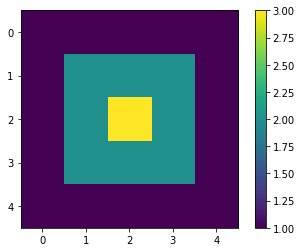

In [ ]:
## MAIN ##

# Initialization 
N = 5
nSubdomains = 1
periodicFlag = False
diagonalLinksFlag = True
neighbors = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
seeds = [{int(N*N/2)}]

# Advance!
groundLevel = zeros(N*N)
iIter, territories, stopper, fronts = advance(seeds, 4, groundLevel)
groundLevel = frontsToGroundLevel(fronts)
plotGroundLevel(groundLevel, N)

In [ ]:
# Define all points in filament
filament = set()
filament.update(arange(N*N))
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
print(filamentConnectivity)

defaultdict(None, {0: {0, 1, 2, 5, 6, 7, 10, 11}, 1: {0, 1, 2, 3, 5, 6, 7, 8, 10, 11}, 2: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, 3: {1, 2, 3, 4, 6, 7, 8, 9, 13, 14}, 4: {2, 3, 4, 7, 8, 9, 13, 14}, 5: {0, 1, 2, 5, 6, 7, 10, 11, 15, 16}, 6: {0, 1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 15, 16}, 7: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13}, 8: {1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 18, 19}, 9: {2, 3, 4, 7, 8, 9, 13, 14, 18, 19}, 10: {0, 1, 5, 6, 10, 11, 15, 16, 20, 21}, 11: {0, 1, 5, 6, 7, 10, 11, 12, 15, 16, 17, 20, 21}, 12: set(), 13: {3, 4, 7, 8, 9, 12, 13, 14, 17, 18, 19, 23, 24}, 14: {3, 4, 8, 9, 13, 14, 18, 19, 23, 24}, 15: {5, 6, 10, 11, 15, 16, 17, 20, 21, 22}, 16: {5, 6, 10, 11, 12, 15, 16, 17, 18, 20, 21, 22, 23}, 17: {11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24}, 18: {8, 9, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24}, 19: {8, 9, 13, 14, 17, 18, 19, 22, 23, 24}, 20: {10, 11, 15, 16, 17, 20, 21, 22}, 21: {10, 11, 15, 16, 17, 18, 20, 21, 22, 23}, 22: {15, 16, 17, 18, 19, 20, 21, 22, 23, 24}

# STEP 3: LOWER PYRAMIDAL

## Functions

In [19]:
def lowerPyramidal(neighbors, groundLevel):
    seeds = []
    minIter = min(groundLevel)
    for dof in range(N*N):
        if groundLevel[dof] == minIter:
            seedList = [dof]
            for neighbor in neighbors[dof]:
                if groundLevel[neighbor] == minIter:
                    seedList.append(neighbor)
            if set(seedList) not in seeds:
                seeds.append(set(seedList))
    nIters = 2*max(groundLevel) + 1
    iIter, territories, stopper, fronts = advance(seeds, nIters, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
    return groundLevel

# STEP 4: DUAL BRIDGES

# STEP 5: (Repeat step 1)

# MAIN

## INITIALIZE

In [28]:
# Initialization 
N = 10
nSubdomains = 4
periodicFlag = False
diagonalLinksFlag = True
neighbors = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
PARALLEL_FLAG = True

## STEP 1: UPPER PYRAMIDAL


1
2
3
4
There are 4 subdomains/processors/GPU blocks in this step
Subdomain 0- DOFs are: {64, 70, 71, 72, 73, 74, 80, 81, 82, 83, 84, 90, 91, 92, 93, 94, 50, 51, 52, 53, 54, 60, 61, 62, 63}
Subdomain 1- DOFs are: {55, 57, 56, 58, 59, 65, 66, 67, 68, 69, 76, 75, 77, 78, 79, 85, 86, 87, 88, 89, 95, 96, 97, 98, 99}
Subdomain 2- DOFs are: {0, 1, 2, 3, 4, 10, 11, 12, 13, 14, 20, 21, 22, 23, 24, 30, 31, 32, 33, 34, 40, 42, 41, 43, 44}
Subdomain 3- DOFs are: {5, 6, 7, 8, 9, 15, 16, 17, 18, 19, 25, 26, 27, 28, 29, 35, 36, 37, 38, 39, 45, 46, 49, 48, 47}


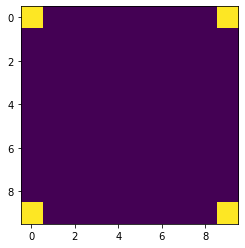

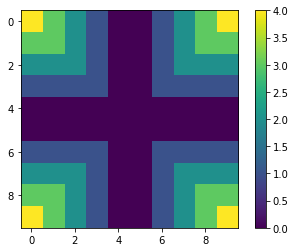

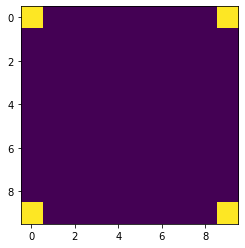

In [29]:
## STAGE 1: UPPER PYRAMIDAL MAIN ##

# Find the far apart seeds
seeds = findSeedsApart(neighbors, nSubdomains)
plotSeeds(seeds,N)

# Use advance to obtain territories
numDofs = len(neighbors)
groundLevel = zeros(numDofs)
iIter, territories, stopper, _ = advance(seeds, 0, groundLevel)

# Use pyMETIS to ensure all dofs have an associated subdomain
neighborsDummy = create2Dneighbors(N, periodic=periodicFlag, diagonalLinks=diagonalLinksFlag)
territorySetUpperPyramidal = createSubdomainsWithMETIS(neighborsDummy, seeds, territories)

# Obtain the seed dofs for each subdomain
seeds = upperPyramidal(territorySetUpperPyramidal, neighbors)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetUpperPyramidal, seeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, neighbors, territorySetUpperPyramidal, seeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetUpperPyramidal)
else:
    iIter, territories, stopper, fronts = advance(seeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
    
# Plot Ground Level and new seeds
plotGroundLevel(groundLevel, N)
plotSeeds(seeds, N)

# Print out information pertaining to the upper pyramidal step
numSubdomainsUpperPyramidal = len(territorySetUpperPyramidal)
print("There are " + str(numSubdomainsUpperPyramidal) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsUpperPyramidal):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetUpperPyramidal[i]))

## STEP 2: BRIDGE STAGE 

In [30]:
def advanceKeepGoing(seeds, nIters, groundLevel):
    fronts = [{1:set(s)} for s in seeds]
    territories = -ones(len(groundLevel), int)
    for i in range(len(seeds)):
        for p in seeds[i]:
            territories[p] = i
    stopper = set()
    iIter = 0
    while iIter + 1 != nIters:
        for iSeed in range(len(seeds)):
            fronts[iSeed][0] = set()
            for ilevel in range(iIter+1, 0, -1):
                for pFront in fronts[iSeed][ilevel]:
                    for pNbr in neighbors[pFront]:
                        if territories[pNbr] < 0 and groundLevel[pNbr] < ilevel:
                            fronts[iSeed][ilevel-1].add(pNbr)
                            territories[pNbr] = iSeed
            for ilevel in range(iIter+1, -1, -1):
                fronts[iSeed][ilevel+1] = fronts[iSeed][ilevel]
            del fronts[iSeed][0] 
        iIter = iIter+1
    return iIter, territories, fronts

4
[0, 23, 46, 69, 92, 115, 138, 161, 184, 207, 230, 253, 276, 299, 322, 345, 368, 391, 414, 437, 460, 483, 506, 529, 552, 575, 598, 621, 644, 667, 690, 713, 736]
33
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7, 10, 12, 14, 16, 18, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 0, 1, 2, 3, 4, 5, 6, 7, 11, 13, 15, 17, 19, 21, 23, 24, 25, 26, 27, 28, 29, 30, 31, 0,

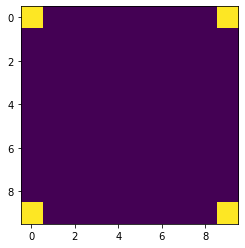

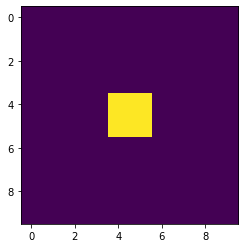

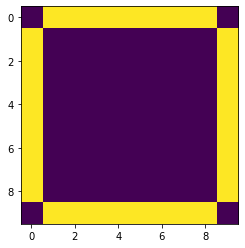

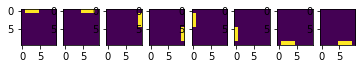

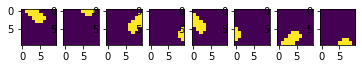

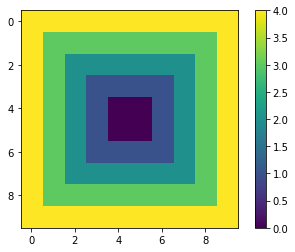

In [34]:
## STAGE 2: BRIDGE STAGE MAIN ##

# Obtain the dual seeds
dualSeeds = findDualSeeds(groundLevel, territorySetUpperPyramidal, neighbors)
dualSeeds = removeCloseSeeds(dualSeeds, iIter+1, groundLevel, neighbors)

# Plot the seeds
plotSeeds(seeds, N)
plotSeeds(dualSeeds, N)

# Obtain the filament regions
filament = obtainFilamentBridgeRegion(dualSeeds, groundLevel)
filament = filamentRemoveSeeds(filament, seeds)
plotTerritoriesSet([filament], N)

# Use METIS to cut the filament region into different pieces
nparts = 8
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
map, reverseMap = filamentMappingforMETIS(filament)
filamentMapped, filamentConnectivityMapped = constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map)
xadj1, adjncy1, eweights1 = constructMETISDataStructures(filamentMapped, filamentConnectivityMapped)
print(xadj1)
print(len(xadj1))
print(adjncy1)
print(len(adjncy1))
print(eweights1)
print(len(eweights1))
# createMETISGraphFile(xadj1, adjncy1, eweights1)
n_cuts, membership = pymetis.part_graph(nparts, xadj=xadj1, adjncy=adjncy1, eweights=eweights1)
bridges = membershipToBridges(nparts, membership, reverseMap)
plotBridges(bridges, N)

# Preprocessing
bridgeSeeds = bridges
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
_, territories, _ = advanceKeepGoing(bridgeSeeds, iIter, groundLevel)
territorySetBridge = territorySetCreator(territories)
territorySetBridgeExpanded = expandTerritorySet(territorySetBridge, neighbors)
plotTerritoriesSet(territorySetBridge, N)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetBridgeExpanded, bridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetBridgeExpanded, bridgeSeeds, iIter, neighbors) 
    groundLevelB = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetBridge)
else:
    # Advance using the bridge
    iIter, territories, stopper, fronts = advance(bridgeSeeds, 0, groundLevel)
    groundLevelB = frontsToGroundLevel(fronts)

# Plot Ground Level
plotGroundLevel(groundLevelB, N)

# Print out information pertaining to the bridge step
numSubdomainsBridge = len(territorySetBridge)
print("There are " + str(numSubdomainsBridge) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsBridge):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetBridgeExpanded[i]))
    print("                       only the following DOFs are updated: " + str(territorySetBridge[i]))

## STEP 3: LOWER PYRAMIDAL

There are 3 subdomains/processors/GPU blocks in this step
Subdomain 0- DOFs are: {521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 583, 584, 585, 586, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 172, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 721, 722, 723, 724, 725, 726, 727, 728, 729, 730, 731, 732, 733, 734, 735, 736, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 821, 822, 823, 824, 825, 826, 827, 828, 829, 830, 831, 832, 833, 834, 835, 836, 321, 322, 323, 324, 325, 326, 327, 328

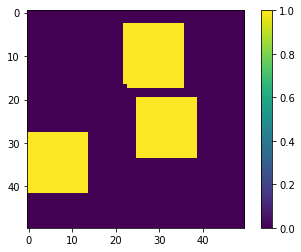

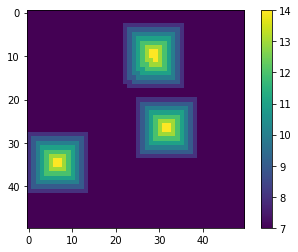

In [ ]:
# Preprocessing
iIter = int(max(groundLevel)) - int(min(groundLevel))
_, territories, stopper, fronts = advance(dualSeeds, 2*iIter, groundLevel)
territorySetLowerPyramidal = territorySetCreator(territories)
plotTerritoriesAllSet(territorySetLowerPyramidal, N)
territorySetLowerPyramidalExpanded = expandTerritorySet(territorySetLowerPyramidal, neighbors)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetLowerPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

# Print out information pertaining to the bridge step
numSubdomainsLowerPyramidal = len(territorySetLowerPyramidal)
print("There are " + str(numSubdomainsLowerPyramidal) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsLowerPyramidal):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetLowerPyramidalExpanded[i]))
    print("                       only the following DOFs are updated: " + str(territorySetLowerPyramidal[i]))

## STEP 4: DUAL BRIDGES

There are 4 subdomains/processors/GPU blocks in this step
Subdomain 0- DOFs are: {2048, 2049, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2218, 2219, 2220, 2221, 2222, 2223, 2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235, 2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247, 2248, 2249, 2267, 2268, 2269, 2270, 2271, 2272, 2273, 2274, 2275, 2276, 2277, 2278, 2279, 2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289, 2290, 2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2316, 2317, 2318, 2319, 2320, 

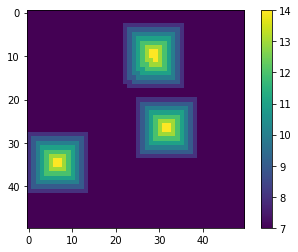

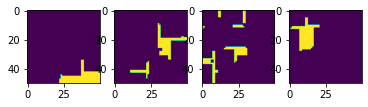

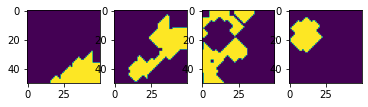

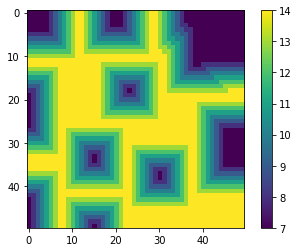

In [ ]:
# Obtain the filament regions
plotGroundLevel(groundLevel, N)
filament = obtainFilamentBridgeRegion(seeds, groundLevel)
filament = filamentRemoveSeeds(filament, dualSeeds)

# Use METIS to cut the filament region into different pieces
nparts = 4
filamentConnectivity = filamentConnectivityConstructor(filament, neighbors, groundLevel)
map, reverseMap = filamentMappingforMETIS(filament)
filamentMapped, filamentConnectivityMapped = constructMappedFilamentAndConnectivity(filament, filamentConnectivity, map)
xadj1, adjncy1, eweights1 = constructMETISDataStructures(filamentMapped, filamentConnectivityMapped)
n_cuts, membership = pymetis.part_graph(nparts, xadj=xadj1, adjncy=adjncy1, eweights=eweights1)
bridges = membershipToBridges(nparts, membership, reverseMap)

# Advance using the bridge
plotBridges(bridges, N)
#iIter, territories, stopper, fronts = advance(bridges, max(groundLevel)+1, groundLevel)
#groundLevel = frontsToGroundLevel(fronts)
#plotGroundLevel(groundLevel, N)

# Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
dualBridgeSeeds = bridges
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
# _, territories, stopper, fronts = advance(dualBridgeSeeds, int(max(groundLevel)), groundLevel)
_, territories, _ = advanceKeepGoing(dualBridgeSeeds, int(max(groundLevel)), groundLevel)
territorySetDualBridge = territorySetCreator(territories)
plotTerritoriesSet(territorySetDualBridge, N)
# from above territorySetUpdateBridge
territorySetDualBridgeExpanded = expandTerritorySet(territorySetDualBridge, neighbors)

# Advance
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetDualBridge)
else:
    iIter, territories, stopper, fronts = advance([filament], max(groundLevel)+1, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

# Print out information pertaining to the bridge step
numSubdomainsDualBridge = len(territorySetDualBridge)
print("There are " + str(numSubdomainsDualBridge) + " subdomains/processors/GPU blocks in this step")
for i in range(numSubdomainsDualBridge):
    print("Subdomain " + str(i) + "- DOFs are: " + str(territorySetDualBridgeExpanded[i]))
    print("                       only the following DOFs are updated: " + str(territorySetDualBridge[i]))

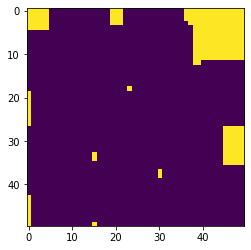

In [ ]:
plotSeeds(seeds, N)

## STEP 5: Repeat step 1


In [ ]:
def stageAdvance(groundLevel, seeds, territorySet, territorySetExpanded, neighbors, nIters, PARALLEL_FLAG=True):
    if PARALLEL_FLAG == True:
        # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
        groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetExpanded, seeds, neighbors)
        groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetExpanded, seeds, nIters, neighbors)
        groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySet)
    else:
        # Advance
        iIter, territories, stopper, fronts = advance(seeds, 0, groundLevel)
        groundLevel = frontsToGroundLevel(fronts)
    return groundLevel

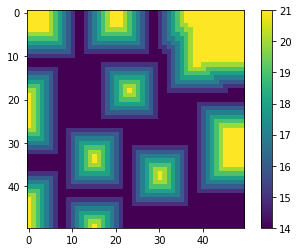

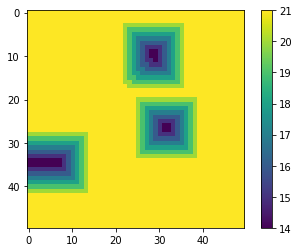

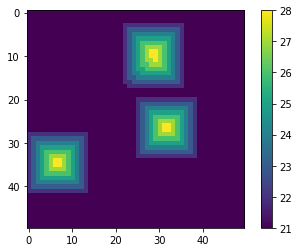

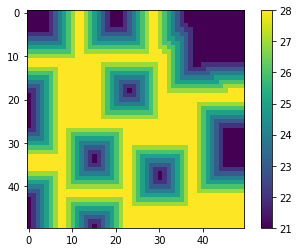

In [ ]:
## Repeat upper pyramidal, bridge, lower pyramidal, dual bridge

numCycles = 2
for cycle in arange(1,numCycles):
    ## STAGE 1: UPPER PYRAMIDAL STAGE ##
    groundLevel = stageAdvance(groundLevel, seeds, territorySetUpperPyramidal, territorySetUpperPyramidal, neighbors, 2*iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 2: BRIDGE STAGE ##
    groundLevel = stageAdvance(groundLevel, bridgeSeeds, territorySetBridge, territorySetBridgeExpanded, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 3: LOWER PYRAMIDAL STAGE ##
    groundLevel = stageAdvance(groundLevel, dualSeeds, territorySetLowerPyramidal, territorySetLowerPyramidalExpanded, neighbors, 2*iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)
    ## STAGE 4: DUAL BRIDGE SEEDS ##
    groundLevel = stageAdvance(groundLevel, dualBridgeSeeds, territorySetDualBridge, territorySetDualBridgeExpanded, neighbors, iIter, PARALLEL_FLAG=True)
    plotGroundLevel(groundLevel, N)

### The long way...

In [ ]:
## Repeat upper pyramidal, bridge, lower pyramidal, dual bridge

## STAGE 1: UPPER PYRAMIDAL STAGE ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetUpperPyramidalExpanded, seeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetUpperPyramidalExpanded, seeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetUpperPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)
# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 2: BRIDGE STAGE ##
iIter = int(max(groundLevel)) - int(min(groundLevel)) 
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetBridgeExpanded, bridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetBridgeExpanded, bridgeSeeds, iIter, neighbors) 
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetBridge)
else:
    # Advance using the bridge
    iIter, territories, stopper, fronts = advance(bridgeSeeds, 0, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)
# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 3: LOWER PYRAMIDAL STAGE ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetLowerPyramidalExpanded, dualSeeds, 2*iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetLowerPyramidal)
else:
    # Advance using the bridge
    groundLevel = lowerPyramidal(neighbors, groundLevel)

# Plot Ground Level
plotGroundLevel(groundLevel, N)

In [ ]:
## STAGE 4: DUAL BRIDGE SEEDS ##
if PARALLEL_FLAG == True:
    # Parallel Advance (simulate being on the GPU and partitioning data between shared memory)
    groundLevelAllSubdomains = groundLevelPartition(groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, neighbors)
    groundLevelAllSubdomains = parallelAdvance(groundLevelAllSubdomains, groundLevel, territorySetDualBridgeExpanded, dualBridgeSeeds, iIter, neighbors)
    groundLevel = groundLevelCombine(groundLevel, groundLevelAllSubdomains, territorySetDualBridge)
else:
    iIter, territories, stopper, fronts = advance([filament], max(groundLevel)+1, groundLevel)
    groundLevel = frontsToGroundLevel(fronts)

# Plot Ground Level
plotGroundLevel(groundLevel, N)